In [39]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import random
from zayd import fista
import timeit
from itertools import combinations

float_formatter = lambda x: "%.3f" % x
np.set_printoptions(formatter={'float_kind':float_formatter})

# 1. Preliminaries

## Load basis functions

In [3]:
'''Load a dictionary of 300 basis functions, each with
dimensions of 16 x 16 pixels.  (~1.2 times overcomplete)'''

bases = np.load('basis1.npz')['basis']
pixels = 16

## Display 100 basis functions

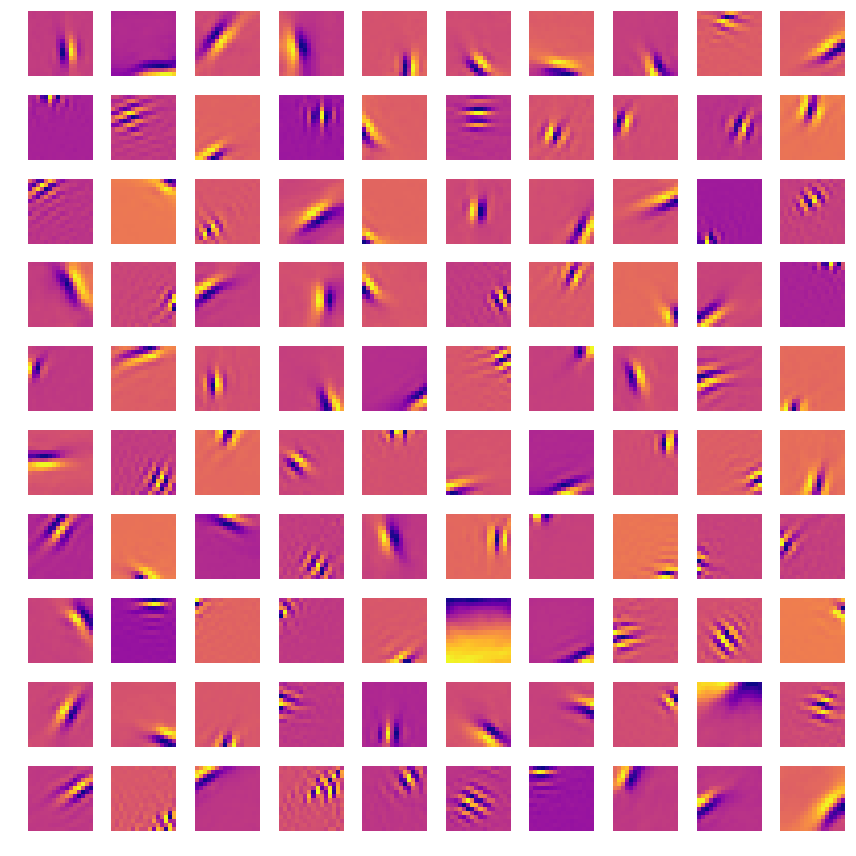

In [5]:
fig, axes = plt.subplots(nrows=10, ncols=10, sharex=True, sharey=True, figsize = (12,12), facecolor = 'white')
axes = axes.ravel()

for i in range(100):      
    axes[i].imshow(np.reshape(bases[:,i], (pixels, pixels)), cmap = 'plasma')
    axes[i].axis('off')
    
plt.tight_layout(h_pad = 1, w_pad = 1)
plt.show()

## Load natural images

In [6]:
IMAGES = scipy.io.loadmat('./zayd/IMAGES.mat')
IMAGES = IMAGES['IMAGES']
(imsize, imsize, num_images) = np.shape(IMAGES)

In [7]:
def sample_images(sample_size, IMAGES):
    border = 4  #buffer around the edge of an entire image
    imi = np.ceil(num_images * random.uniform(0, 1))  #pick a random image
    I = np.zeros((pixels**2,sample_size))

    for i in range(sample_size):
        r = border + np.ceil((imsize-pixels-2*border) * random.uniform(0, 1))
        c = border + np.ceil((imsize-pixels-2*border) * random.uniform(0, 1))
        image = IMAGES[int(r):int(r+pixels), int(c):int(c+pixels), int(imi-1)]
        I[:,i] = np.reshape(image, pixels**2) 
        
    return I

In [25]:
I = sample_images(1000, IMAGES)

In [26]:
ahat = fista.fista(I, bases, lambdav = 0.1, max_iterations=50)

In [27]:
for i,j in combinations(range(300),2):
    corr = np.corrcoef(ahat[i,:], ahat[j,:])[0, 1]
    if abs(corr) > 0.4 and i != j:
        print(i,j)

16 153
16 172
57 269
67 81
80 209
84 117
104 265
104 285
108 111
108 239
108 266
111 289
117 239
118 277
147 172
210 224
210 290
224 290
266 291
269 282


0.406794302526


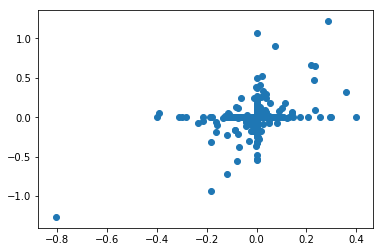

In [38]:
plt.scatter(ahat[67,:], ahat[81,:])
print(np.corrcoef(ahat[67,:], ahat[81,:])[0, 1])
plt.show()

In [31]:
for i in range(len(ahat[90,:])):
    if abs(ahat[67,:][i]) > 0.6 and abs(ahat[81,:][i]) > 0.6:
        print(i)

835


In [32]:
def add_noise(image, sigma = 1e-2):
    noise = np.random.normal(0.0, sigma, image.shape)
    return image + noise

def plot_neurons(i,j):
    neuron1 = responses[i,:]
    neuron2 = responses[j,:]
    print(np.corrcoef(neuron1,neuron2)[0, 1])
    plt.scatter(neuron1, neuron2)
    plt.show()

In [34]:
num_trials = 1000
responses = np.zeros((bases.shape[1], num_trials))
selected_image = np.reshape(I[:,835], (256,1))

for i in range(num_trials):
    ahat2 = fista.fista(add_noise(selected_image, 1e-2), bases, lambdav = 0.1, max_iterations = 50)
    responses[:, i] = ahat2[:, 0]

-0.475235627728


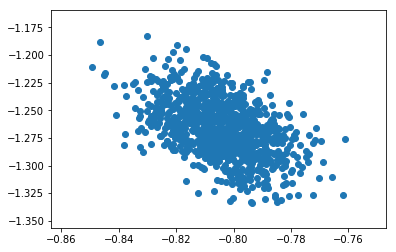

In [40]:
plot_neurons(67,81)

## Extras

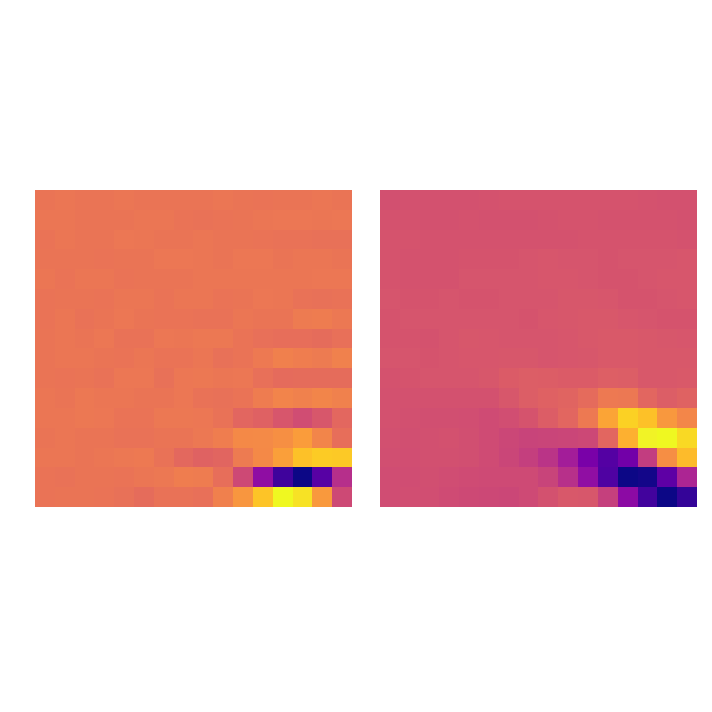

In [50]:
num_images = 15
pixels = 16

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize = (10,10), facecolor = 'white')

axes = axes.ravel()
j = 0
for i in [67,81]:      
    axes[j].imshow(np.reshape(bases[:,i], (pixels, pixels)), cmap = 'plasma')
    axes[j].axis('off')
    j += 1
    
plt.tight_layout(h_pad = 1, w_pad = 1)
plt.show()

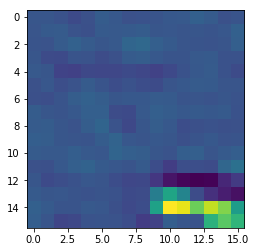

In [51]:
plt.imshow(np.reshape(I[:,835], (pixels, pixels)))
#plt.imshow(np.reshape(add_noise(I[:,1894], 0.1), (pixels,pixels)))
plt.show()

256


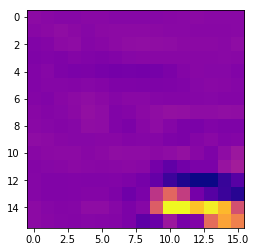

In [52]:
reco = np.dot(bases, responses[:, 1])
plt.imshow(np.reshape(reco, (pixels,pixels)), cmap = 'plasma')
print(reco.size)
plt.show()

In [53]:
print(ahat.shape)

(300, 1000)


67
81
159
190
203
264


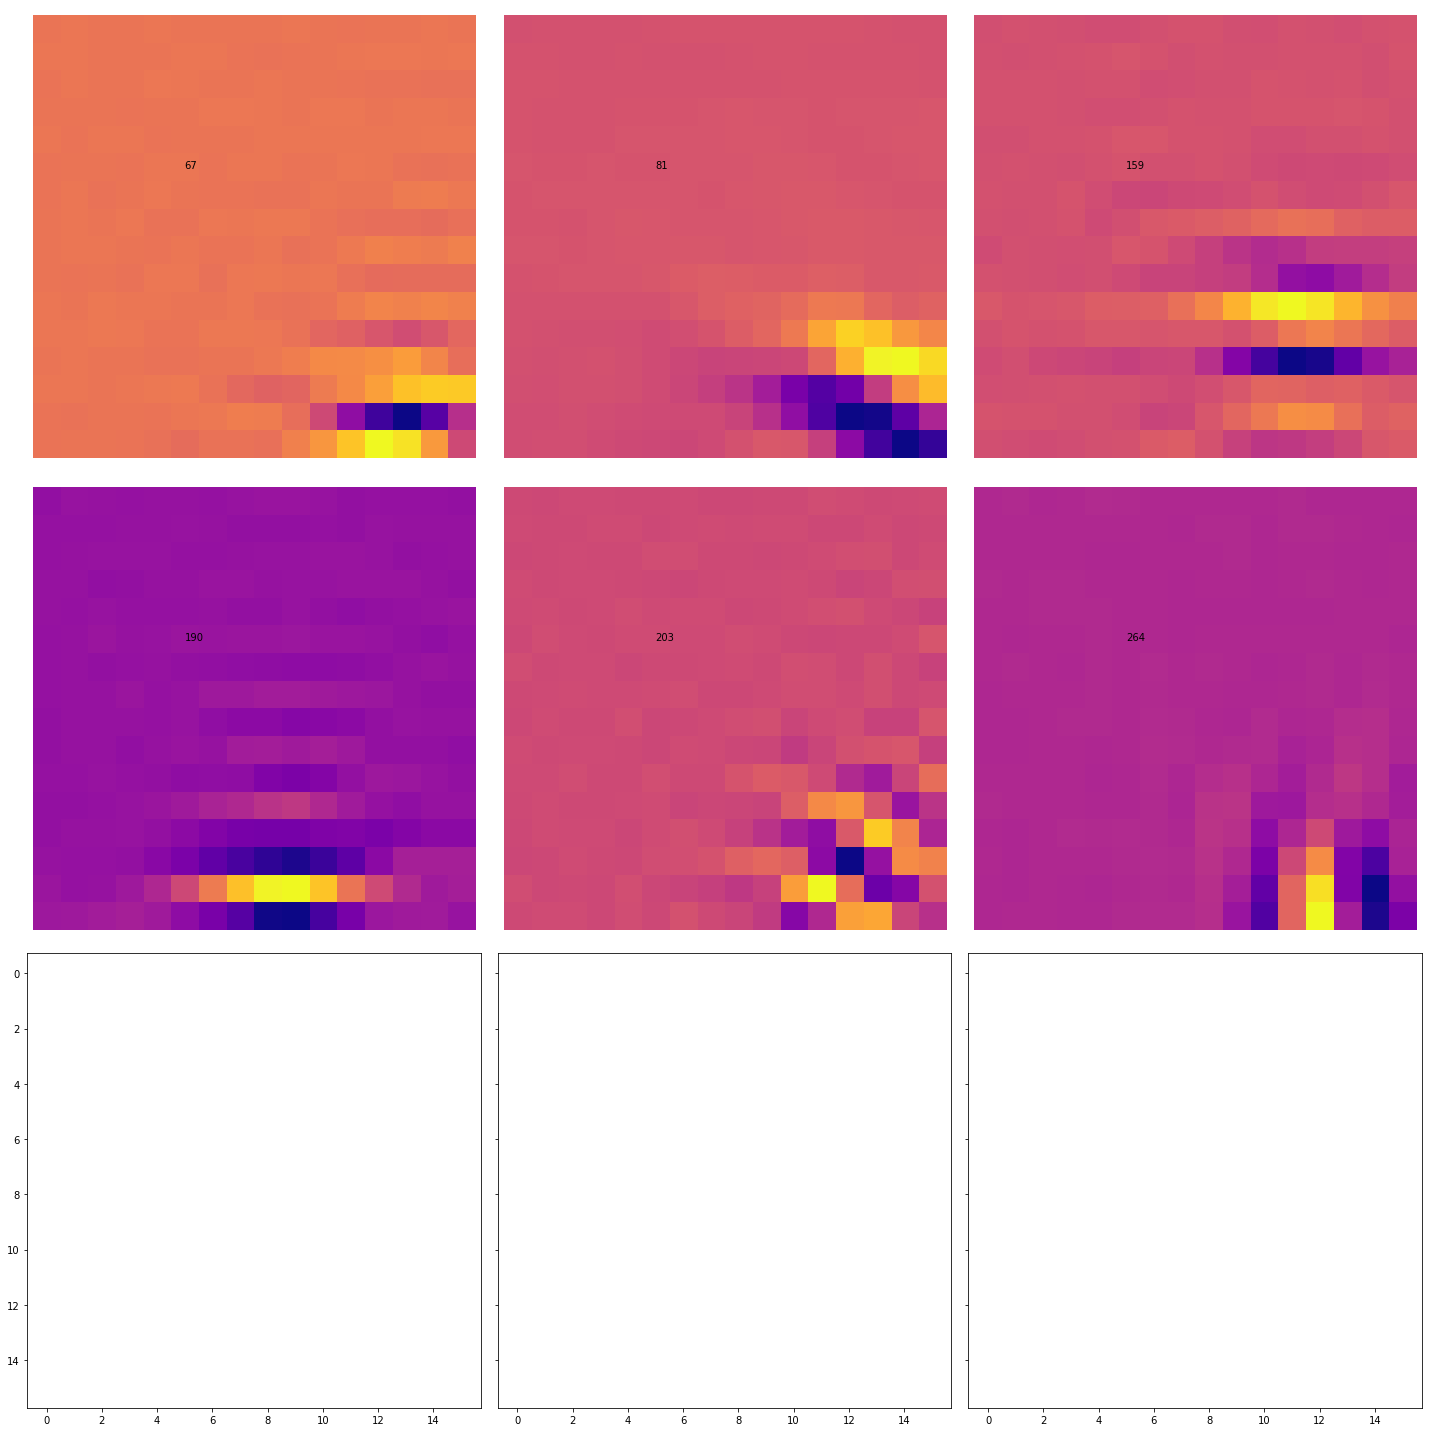

In [59]:
fig, axes = plt.subplots(nrows=3, ncols=3, sharex=True, sharey=True, figsize = (20,20), facecolor = 'white')
j = 0
partial_reco = np.zeros(256)
axes = axes.ravel()
for i in range(len(ahat)):  
    if abs(ahat[i,835]) > 0.3:
        print(i)
        #partial_reco += ahat[i]*bases[:,i]
        axes[j].imshow(np.reshape(bases[:,i], (pixels, pixels)), cmap = 'plasma')
        axes[j].text(5,5,str(i))
        axes[j].axis('off')
        j += 1
    
plt.tight_layout(h_pad = 1, w_pad = 1)
plt.show()

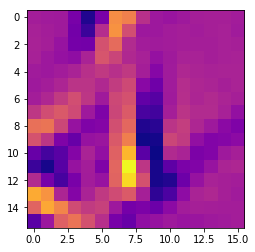

In [74]:
plt.imshow(np.reshape(partial_reco, (pixels, pixels)), cmap = 'plasma')
plt.show()

In [47]:
sums = []
thresh = np.arange(0,1,0.005)
for i in thresh:
    sums.append(np.sum(np.abs(ahat)>i))

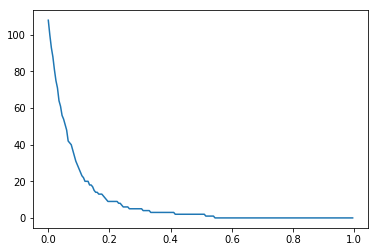

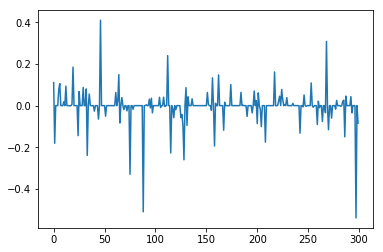

In [33]:
plt.plot(thresh, sums)
plt.show()
plt.plot(ahat)
plt.show()